# Basics to BattleSimulation

Throughout these teaching notebooks, we're going to take you step-by-step through the development and considerations we make when producing an simulation software that uses units.

In this notebook (**1**) we are going to cover:

- **[Creating a Dataset of Units](#c1)**
- **[Implementations of the Simulation](#c2)**
- **[Defining euclidean distance](#c3)**
- **[Defining the directional derivative](#c4)**
- **[Defining movement of units](#c5)**
- **[Defining the simulation](#c6)**
- **[Post-simulation analysis](#c7)**

Click on any of the links to jump to that section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

## <a id='c1'> Creating a Dataset of Units

The basic building block of this project is the `Unit`. Units have a number of attributes to them which we make subject to the simulation software in order to manipulate their position, health, armor, range, damage etc, in order for a certain team to win.

In most of these examples, we draw from the Clone Wars as inspiration as a fight between the Clones and the Droids/Separatists:

| Name | Team | HP | Range | Damage |
| --------------- | ------------- | ----- |--------- |------ |
| Clone trooper | Republic | 35 | 3 | 16 |
| B1 battledroid | CIS | 20 | 2.5 | 15 | 
| ... | ... | ... | ... | ... |
| Magmaguard | CIS | 200 | 0.4 | 200 |

Once we have this dataset of stats, we can infer the properties mentioned above.

### Utility code

First of all we have a few utility functions for handling common situations.

In [2]:
def check_columns(df, list_of_columns):
    for l in list_of_columns:
        if l not in df.columns:
            raise ValueError("column '{}' not found in dataframe.".format(l))

### Loading in the dataset

For this, we set a template of what the file should look like before we import it. This makes sure that the simulation code can be confident that the variables described actually exist.

In [3]:
accepted_db_columns = [
    "Name", "Allegiance", "HP", "Damage", "Accuracy",
    "Miss", "Movement Speed", "Range"
]

In [4]:
def import_db_file(fpath):
    """
    Imports our dataset of information, given a file path.
    """
    if not os.path.isfile(fpath):
        raise IOError("fpath does not exist.")
    # attempt to read in
    df = pd.read_csv(fpath)
    # check columns exist
    check_columns(df, accepted_db_columns)
    df.set_index("Name", inplace=True)
    # assign an integer to allegiance
    df["allegiance_int"] = pd.factorize(df["Allegiance"])[0]
    return df

In [5]:
db_ = import_db_file("../datasets/starwars-clonewars.csv")
db_

,Allegiance,Type,Armor,HP,Damage,Dmg Speed,Range,Movement Speed,Accuracy,Miss,Shield,Shield Regen,allegiance_int
Name,,,,,,,,,,,,,
Local Militia,Republic,Standard,15,20,10,1.00,2.0,0.6,5,30,0,0.00,0
B1 battledroid,CIS,Standard,35,20,15,1.00,2.5,0.5,30,35,0,0.00,1
Clone Trooper,Republic,Standard,50,35,16,1.20,3.0,0.7,65,75,0,0.00,0
B2 battledroid,CIS,Standard,100,40,20,1.20,3.5,0.4,70,40,0,0.00,1
ARC Trooper,Republic,Elite,100,100,20,0.90,5.0,1.0,90,95,0,0.00,0
BX-series droid commando,CIS,Elite,70,50,22,1.30,7.0,0.8,70,95,0,0.00,1
Clone Sharpshooter,Republic,Specialist,50,40,50,0.20,15.0,0.2,60,40,0,0.00,0
Battle droid assassin,CIS,Specialist,60,20,50,0.15,15.0,0.2,55,45,0,0.00,1
Clone Commando,Republic,Elite,100,120,20,1.50,3.0,0.9,97,97,30,0.20,0


## <a id='c2'> Implementations of the Simulation

Given these data values, we need to think of a way to construct a system that can create 'instances' of each Unit and simulate their movement, health etc. There are a number of approaches one could take:

1. An **object-orientated approach**. This involves creating a `Unit` object class which is instantiated, contains every units' health, movement, etc. This 'list of Units' is then passed to a given simulation function to run.
2. A **matrix-orientated approach**. This involves creating a $N\times P$ matrix where $N$ is the number of units and $P$ is the number of features or Unit attributes. This Matrix is then used to perform dynamic changes to the unit in time.

### Approach 1. `Unit` class

Below is an implementation of an example `Unit` class.

In [6]:
class Unit(object):
    def __init__(self, db, name):
        """
        Defines a unit, based on examples in the 'db' file, given a name. Assumes the name
        is the index in db.
        """
        # check that name is in db.index
        if not name in db.index:
            raise ValueError("unit {} must be in {}".format(name, db.index))
        self.name = name
        self.hp = db.loc[name, "HP"]
        self.dmg = db.loc[name, "Damage"]
        self.range = db.loc[name, "Range"]
        self.speed = db.loc[name, "Movement Speed"]
        self.team = db.loc[name, "allegiance_int"]
        self.team_name = db.loc[name, "Allegiance"]
        
        # define position
        self.pos = np.array([0., 0.])
        # directional derivative from target. 
        self.dd = np.array([0., 0.])
        # distance from target
        self.dist = 0.
        # define target to aim for
        self.target = None

And so from this, we can create units like so:

In [7]:
u1 = Unit(db_, "Clone Trooper")
u1.name

'Clone Trooper'

Of course, we need to set the position of this unit, which we can do to override the `unit.pos` attribute:

In [8]:
u1.pos = np.array([5., 5.])

We'll create another `Unit` of the enemy team:

In [9]:
u2 = Unit(db_, "B1 battledroid")
u2.name

'B1 battledroid'

### Setting targets

These units have to be set as each other in terms of the `unit.target` attribute:

In [10]:
u1.target = u2
u2.target = u1

### <a id='c3'> Defining euclidean distance function

In order to move the units in 2D space, we have to define how far units are from each other when it comes to calculating whether they are in range to strike. This is determined by the positions and the `range` parameter given to each unit type.

The euclidean distance is defined mathematically as:

$$
d(\textbf{p}, \textbf{q}) = d(\textbf{q}, \textbf{p}) = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \dots + (q_n - p_n)^2} = \sqrt{\sum_{i=1}^n \left(q_i - p_i \right)^2}
$$

where $n$ refers to the number of dimensions. Contrasted to the **magnitude** of a vector, which measures it's length:

$$
||\textbf{p}||=\sqrt{p_1^2 + p_2^2 + \dots + p_n^2} = \sqrt{\textbf{p} \cdot \textbf{p}}
$$

In [11]:
def euclidean(u_i, u_j):
    """where x and y are np.array(2,) objects"""
    return np.sqrt(np.sum(np.square(u_i - u_j)))


def magnitude(p):
    return np.sqrt(np.dot(p, p))

### <a id='c4'> Defining directional derivative

The directional derivative $\nabla_{\textbf{u}} f(x_0, y_0)$ is the rate at which the function $f(x, y)$ changes at a point $(x_0, y_0)$ in the direction $\textbf{u}$. It is defined as:

$$
\begin{align}
\nabla_{\mathbf{u}} f \equiv \nabla f \cdot \frac{\mathbf{u}}{|\mathbf{u}|} \\
= \lim_{h \to 0} \frac{f(\mathbf{x} + h \, \hat{\mathbf{u}}) - f(\mathbf{x})}{h}
\end{align}
$$

where $\mathbf{u}=[\mathbf{x}, \mathbf{y}]$. In our case, within *Euclidean space*, the directional derivative is respective to the vector $\mathbf{v}$ after normalization, so it's independent of it's magnitude and depends only on the direction.

### The normalized derivative

Since we exclude the magnitude from our calculation; we normalize for it:

$$
\Delta \mathbf{u}_{i}^{\text{norm}}(\mathbf{u_i},\mathbf{u}_j)=\frac{\mathbf{u}_j - \mathbf{u}_i}{||\mathbf{u}_i - \mathbf{u}_j||}
$$

This is essentially the *negative normalized direction* of the unit. We make it negative such that the unit moves *towards* the enemy rather than away. Note that it is **essential** that $\mathbf{u}_j - \mathbf{u}_i$ rather than $\mathbf{u}_i - \mathbf{u}_j$, otherwise the unit will move in the *other direction away from the target*.

In [12]:
def deriv_norm(u_i, u_j):
    return (u_j - u_i) / euclidean(u_i, u_j)

### <a id='c5'> Defining movement

Determining the change in movement in time is a dynamic process, and we determine this using these formulae:

$$
\dot{\mathbf{u}}_i = \frac{d\mathbf{u}_i}{dt}(\mathbf{u}_i, \mathbf{u}_j) \approx s_i \, \Omega \,  \delta t \, \Delta \mathbf{u}_{i}^{\text{norm}}(\mathbf{u_i},\mathbf{u}_j) \quad \forall i \\
$$

where $s_i$ is the base speed of the unit $i$, $\Omega$ is a global parameter that could be attributed to terrain etc., $\delta t$ is the change in time step (default to 1), unit $j$ is the target that unit $i$ wishes to draw towards, and where $\Delta \mathbf{u}_{i}^{\text{norm}}(\mathbf{u_i},\mathbf{u}_j)$ is our normalized direction for unit $i$. In essense, this is simply the 'speed' of the unit multiplied by the negative direction of the opponent to move in that direction. Note that $ \mathbf{u}_j$ doesn't have to be another Unit, but could be a waypoint for moving a Unit to a particular landmark or location.

In [13]:
u_i = np.array([10., 0.])
u_j = np.array([0., 0.])
u = np.vstack((u_i, u_j))

In [14]:
dudt = lambda u_i, u_j, s_i: (s_i * 1. * 1. * deriv_norm(u_i, u_j))

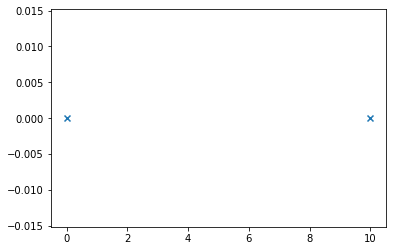

In [15]:
plt.scatter(u[:, 0], u[:, 1], marker='x')
plt.show()

Here we see that unit 1 wishes to increase 1 step in the $x$-direction:

In [16]:
dudt(u_i, u_j, 1.)

array([-1.,  0.])

Whereas unit 2 wishes to decrease in the $x$-direction:

In [17]:
dudt(u_j, u_i, 1.)

array([1., 0.])

In [18]:
du = np.vstack((dudt(u_i, u_j, 1.), dudt(u_j, u_i, 1.)))

Thus we can plot the derivatives in addition to position to use a `quiverplot`:

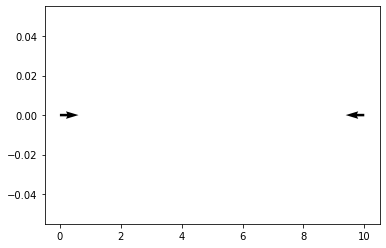

In [19]:
plt.quiver(u[:,0], u[:, 1], du[:, 0], du[:, 1])

### <a id='c6'> Defining the simulation

And now we have at least 2 units, we're going to define our first *basic* simulation. The simulation will only end when:

1. $t < T_{max}$, where $t$ is the timestep and $T_{max}$ is the maximum number of timesteps, set by the user.
2. `running` becomes false. `running` can be set false in a number of ways, for instance, a unit has no target.

We then define the simulation as follows:
    
    t = 0
    while running and t < T_max:
        iterate over all units (i):
            if unit (i) hp > 0: <is alive>
                if unit (i) target hp <= 0:
                    <assign new target>
                else:
                    set directional derivative between unit (i) position and target (i) position
                    calculate distances between unit (i) position and target (i) position
                    if distance > unit (i) range:
                        <move towards enemy unit>
                    else:
                        <perform hit/damage calculation to target>
        t += 1

In [20]:
def basic_simulation(units, max_step=100):
    t = 0
    running = True
    
    # while loop
    while running and t < max_step:
        # iterate over units.
        for i, u in enumerate(units):
            #if we're alive...
            if u.hp > 0:
                # euclidean distance
                u.dd = -deriv_norm(u.pos, u.target.pos)
                u.dist = euclidean(u.pos, u.target.pos)
                # now, if the unit is not in range, then move towards it
                if u.dist > u.range:
                    # speed modifier added, others ignored from above.
                    u.pos += dudt(u.pos, u.target.pos, u.speed)
                else:
                    # perform damage to enemy health.
                    u.target.hp -= u.dmg
        t += 1

In [21]:
basic_simulation([u1, u2])

We can see if we look at the HP of the units, unit 1 did considerably better; has 20 HP whereas unit 2 has negative 1516 HP!

In [22]:
print(u1.hp, u2.hp)

20 -1516


## <a id='c7'> Post-simulation analysis

In order to analyse what's going on properly, we're going to save what's happening in a list at *each time step*. Below is some modified code:

In [23]:
from copy import deepcopy

In [24]:
def basic_simulation2(units, max_step=50):
    t = 0
    running = True
    
    steps = []
    
    # while loop
    while running and t < max_step:
        # iterate over units.
        for i, u in enumerate(units):
            #if we're alive...
            if u.hp > 0:
                # euclidean distance
                u.dd = deriv_norm(u.pos, u.target.pos)
                u.dist = euclidean(u.pos, u.target.pos)
                # now, if the unit is not in range, then move towards it
                if u.dist > u.range:
                    # speed modifier added, others ignored from above.
                    u.pos += dudt(u.pos, u.target.pos, u.speed)
                else:
                    # perform damage to enemy health.
                    u.target.hp -= u.dmg
            
            # save
            steps.append(deepcopy(units))
        t += 1
    
    return steps

In [25]:
u1 = Unit(db_, "Clone Trooper")
u1.pos = np.array([5., 5.])
u2 = Unit(db_, "B1 battledroid")
u1.target = u2
u2.target = u1

Res = basic_simulation2([u1, u2])

#### HP of Unit 2 decreases beyond 0

This is because we do not check whether the alive unit has any valid targets to find... so it keeps on subtracting the target it has.

In [26]:
HP1 = np.array([Res[i][0].hp for i in range(len(Res))])
HP2 = np.array([Res[i][1].hp for i in range(len(Res))])

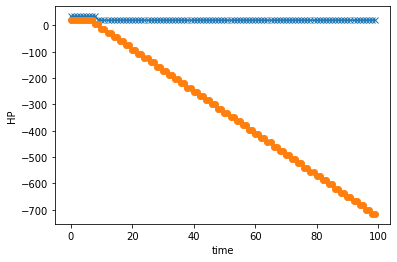

In [27]:
plt.plot(HP1, 'x-')
plt.plot(HP2, 'o-')
plt.xlabel("time")
plt.ylabel("HP")
plt.show()

### Scaling to 4 units (2 v 2)

In [28]:
u1 = Unit(db_, "Clone Trooper")
u2 = Unit(db_, "B1 battledroid")
u3 = Unit(db_, "Clone Trooper")
u4 = Unit(db_, "B1 battledroid")

u1.pos = np.array([-5., 5.])
u3.pos = np.array([5., 5.])

u1.target = u2
u3.target = u4
u2.target = u1
u4.target = u3

Res = basic_simulation2([u1, u2, u3, u4])

In [29]:
def extract_hp(Res, n_units, var="hp"):
    return np.vstack(([np.array([Res[i][j].hp for i in range(len(Res))]) for j in range(n_units)]))

def extract_pos(Res, n_units):
    return np.stack(([np.array([Res[i][j].pos for i in range(len(Res))]) for j in range(n_units)]), axis=2)

def extract_dpos(Res, n_units):
    return np.stack(([np.array([Res[i][j].dd for i in range(len(Res))]) for j in range(n_units)]), axis=2)

Health points in the new group - it still appears HP drops for the B1 battledroids:

In [30]:
HP = extract_hp(Res, 4)

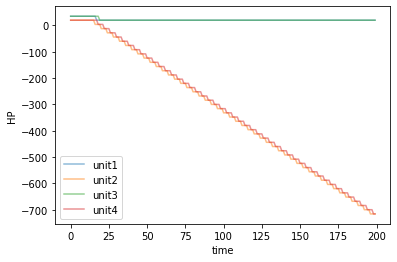

In [31]:
for i, x in enumerate(HP):
    plt.plot(x, alpha=.5, label="unit%d" % (i + 1))
plt.legend()
plt.xlabel("time")
plt.ylabel("HP")
plt.show()

In terms of positioning, we see normal behavior - Units are moving towards their target, and when they are in range, they attack them.

In [32]:
pos = extract_pos(Res, 4)
dd = extract_dpos(Res,4)

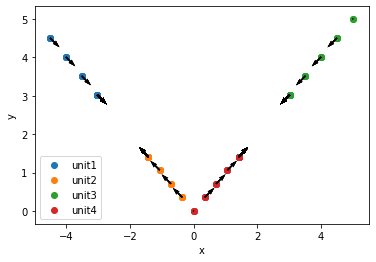

In [33]:
for i in range(pos.shape[-1]):
    plt.scatter(pos[:, 0, i], pos[:, 1, i], label="unit%d" % (i+1))
    plt.quiver(pos[:, 0, i], pos[:, 1, i], dd[:, 0, i], dd[:, 1, i])
    
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

This marks the end of our **basics** to the simulation work. In our next notebook we're going to be making adjustments to our `Unit` class and simulation operating to solve some of the problems raise in this *naive* implementation.